# Amazon Alexa Sentiment Analysis

In [75]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

In [67]:
#reading file
df=pd.read_csv("amazon_alexa.tsv",sep="\t")
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


Exploratory Data Analysis

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
rating              3150 non-null int64
date                3150 non-null object
variation           3150 non-null object
verified_reviews    3150 non-null object
feedback            3150 non-null int64
dtypes: int64(2), object(3)
memory usage: 123.1+ KB


In [21]:
df.shape
df.describe()
df.isna().mean(axis=0)

rating              0.0
date                0.0
variation           0.0
verified_reviews    0.0
feedback            0.0
dtype: float64

There are no null values in the dataset.

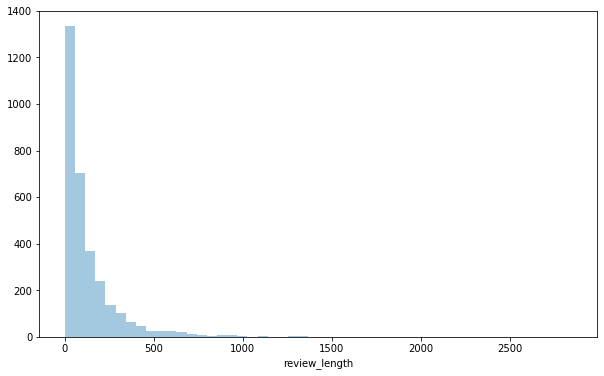

In [32]:
#seeing the distribution of word length
df['review_length']=df['verified_reviews'].apply(len)

fig = plt.figure(1, figsize=(10,6))
sns.distplot(df['review_length'],kde=False);

In [72]:
df['date']=pd.to_datetime(df['date'], format="%d-%b-%y")
df.dtypes

rating                       int64
date                datetime64[ns]
variation                   object
verified_reviews            object
feedback                     int64
dtype: object

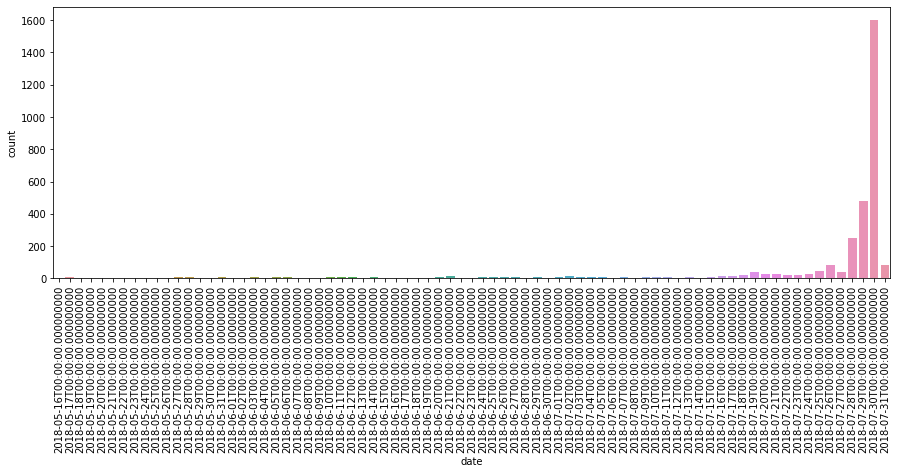

In [71]:
plt.figure(figsize=(15,5))
ax=sns.countplot(df['date'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


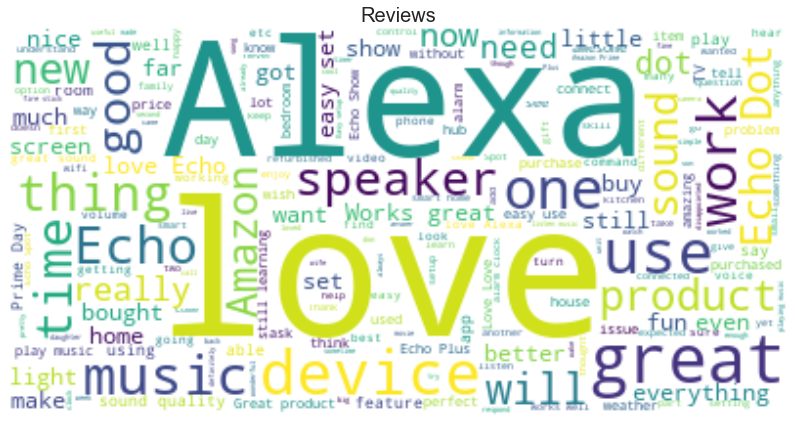

In [79]:
np.random.seed(10)
sns.set(rc={'figure.figsize':(14,8)})
reviews = ' '.join(df['verified_reviews'].tolist())

wordcloud = WordCloud(background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews',size=20)
plt.show()